# Amazon SageMaker Autopilot による顧客離反予測
_**AutoPilot を用いた携帯電話契約の離反予測**_


---

## コンテンツ

1. [はじめに](#introduction)
1. [セットアップ](#setup)
1. [データ](#data)
1. [学習](#trainsetup)
1. [結果](#result)
1. [評価](#evaluation)
1. [後片付け](#cleanup)


---

## 1. はじめに  <a name="introduction"></a>

Amazon SageMaker Autopilot は、表形式のデータセット用の自動機械学習（一般にAutoMLと呼ばれる）ソリューションです。 SageMaker Autopilot は、さまざまな方法で使用できます。Autopilot（本機能の名前）または人間のガイダンス、コードを使わないSageMaker Studio 経由、または AWS SDK の使用、など様々な方法があります。このノートブックは、 AWS SDK を使用して、機械学習モデルを簡単に作成およびデプロイします。

ビジネスにおいて、顧客を失うことはどんなビジネスにとってもコストがかかります。不満を持っている顧客を早期に特定することで、彼らに滞在するインセンティブを提供する機会が与えられます。このノートブックでは、顧客離反予測とも呼ばれる、不幸な顧客の自動識別のための機械学習（ML）の使用について説明します。ただし、ML モデルが完全な予測を行うことはめったにありません。そのため、このノートブックでは、MLを使用した場合の財務結果を決定するときに、予測ミスの相対コストを組み込む方法についても説明します。

私たち全員に馴染みのある携帯電話会社解約の例を使用します。プロバイダーの本日の障害を常に見つけることができるようです！そして、私のプロバイダーが解約しようとしていることを知っていれば、タイムリーなインセンティブを提供できます。いつでも電話のアップグレードを使用したり、新しい機能を有効にしたりできます。インセンティブは多くの場合、顧客を失って再獲得するよりもはるかに費用対効果が高くなります。

---
## 2. セットアップ  <a name="setup"></a>

_このノートブックは、ml.m4.xlarge ノートブックインスタンスで作成およびテストされました。_  

まずは次のように指定します。

- トレーニングとモデルデータに使用する S3 バケットとプレフィックスは、ノートブックインスタンス、トレーニング、ホスティングと同じリージョン内にある必要があります。
- データへのトレーニングとホスティングアクセスを提供するために使用される IAM role の作成方法については、ドキュメントを参照してください。 ノートブックインスタンス、トレーニング、ホスティングに複数の role が必要な場合は、boto regexp を適切な完全な IAM role の文字列に置き換えてください。

In [ ]:
import sagemaker
import boto3
from sagemaker import get_execution_role

region = boto3.Session().region_name
session = sagemaker.Session()

# You can modify the following to use a bucket of your choosing
bucket = session.default_bucket()
prefix = 'sagemaker/DEMO-autopilot-churn'

In [ ]:
role = get_execution_role()

# This is the client we will use to interact with SageMaker AutoPilot
sm = boto3.Session().client(service_name='sagemaker',region_name=region)

次に、残りの演習で必要になる Python ライブラリをインポートします。

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import os
import sys
import time
import json
from IPython.display import display
from time import strftime, gmtime
import sagemaker
from sagemaker.predictor import csv_serializer

---
<a name="data"></a>

## 3. データ 

モバイルオペレーターには、顧客が最終的に解約した場合と、サービスを継続して使用した場合の記録があります。この履歴情報を使用して、機械学習により、1つのモバイルオペレーターの解約予測モデルを構築できます。モデルをトレーニングした後、任意の顧客のプロファイル情報（モデルのトレーニングに使用したのと同じプロファイル情報）をモデルに渡し、この顧客が解約するかどうかをモデルに予測させることができます。 もちろん、私たちはモデルが間違いを犯すことを期待しています。結局のところ、将来を予測することは難しいビジネスです！ただし、予測エラーに対処する方法も示します。

私たちが使用するデータセットは公開されており、Daniel T. Larose 著の [Discovering Knowledge in Data](https://www.amazon.com/dp/0470908742/) で言及されています。 著者はカリフォルニア大学アーバインの機械学習データセットリポジトリに帰属します。 それでは、そのデータセットをダウンロードして読みましょう。

In [ ]:
!wget http://dataminingconsultant.com/DKD2e_data_sets.zip
!unzip -o DKD2e_data_sets.zip

### 3.1. 学習に使うデータセットの確認

データセットに対して Autopilot を実行する前に、まずデータセットをチェックして、明らかなエラーがないことを確認します。 Autopilot のプロセスには時間がかかる場合があります。ジョブを開始する前にデータセットを検査することをお勧めします。 この特定のデータセットは小さいため、ノートブックインスタンス自体で検査できます。ノートブックインスタンスのメモリに収まらない大きなデータセットがある場合は、Apache Spark などのビッグデータ分析ツールを使用して、データセットをオフラインで検査します。[Deequ](https://github.com/awslabs/deequ) は、Apache Spark の上に構築されたライブラリで、大きなデータセットのチェックを実行するのに役立ちます。 Autopilot は、最大 5GB のデータセットを処理できます。

データを Pandas データフレームに読み込み、確認します。

In [ ]:
churn = pd.read_csv('./Data sets/churn.txt')
pd.set_option('display.max_columns', 500)
churn

現代の基準からすると、これらは比較的小さなデータセットであり、3,333レコードしかありません。各レコードは21の属性を使用して、未知の米国の携帯電話会社の顧客のプロファイルを記述しています。 属性は次のとおりです。

- `State`: 顧客が居住する米国の州。2文字の略語で示されます。 たとえば、OHまたはNJ
- `Account Length`: このアカウントがアクティブであった日数
- `Area Code`: 対応する顧客の電話番号の3桁の市外局番
- `Phone`: 残りの7桁の電話番号
- `Int’l Plan`: 顧客が国際通話プランを持っているかどうか: yes/no
- `VMail Plan`: 顧客がボイスメール機能を持っているかどうか: yes/no
- `VMail Message`: 月あたりのボイスメールメッセージの平均数
- `Day Mins`: 日中に使用された通話時間の合計（分）
- `Day Calls`: 日中の通話数の合計
- `Day Charge`: 日中の通話料金
- `Eve Mins, Eve Calls, Eve Charge`: 夕刻の通話料金
- `Night Mins`, `Night Calls`, `Night Charge`: 夜間の通話料金
- `Intl Mins`, `Intl Calls`, `Intl Charge`: 国際電話の請求費用
- `CustServ Calls`: カスタマーサービスにかけられた通話の数
- `Churn?`: 顧客がサービスを終了したかどうか: true/false

最後の属性 `Churn?`は、これからMLモデルで予測する属性ターゲット属性です。

### 3.2. データを S3 にアップロード

データをトレーニングとテストの分割に分割します。 トレーニング分割は SageMaker Autopilot で使用されます。 テストスプリットは、推奨モデルを使用して推論を実行するために予約されています。

In [ ]:
train_data = churn.sample(frac=0.8,random_state=200)

test_data = churn.drop(train_data.index)

test_data_no_target = test_data.drop(columns=['Churn?'])

次に、これらのファイルをS3にアップロードします。

In [ ]:
train_file = 'train_data.csv';
train_data.to_csv(train_file, index=False, header=True)
train_data_s3_path = session.upload_data(path=train_file, key_prefix=prefix + "/train")
print('Train data uploaded to: ' + train_data_s3_path)

test_file = 'test_data.csv';
test_data_no_target.to_csv(test_file, index=False, header=False)
test_data_s3_path = session.upload_data(path=test_file, key_prefix=prefix + "/test")
print('Test data uploaded to: ' + test_data_s3_path)

---
<a name="trainsetup"></a>


## 4. 学習
### 4.1. SageMaker Autopilot ジョブの設定 

データセットを Amazon S3 にアップロードした後、Autopilot を呼び出して、このデータセットでモデルをトレーニングするのに最適な ML パイプラインを見つけることができます。

Autopilot ジョブを呼び出すために必要な入力は次のとおりです。

* 入力データセットおよびすべてのアーティファクト出力のための Amazon S3 ロケーション
* 予測するデータセットの列の名前（この場合は `Churn?` ）
* IAM role

現在、Autopilot はCSV形式の表形式のデータセットのみをサポートしています。 すべてのファイルにヘッダー行があるか、データセットの最初のファイルが名前のアルファベット順または字句順に並べ替えられている場合、ヘッダー行があると予想されます。

In [ ]:
input_data_config = [{
      'DataSource': {
        'S3DataSource': {
          'S3DataType': 'S3Prefix',
          'S3Uri': 's3://{}/{}/train'.format(bucket,prefix)
        }
      },
      'TargetAttributeName': 'Churn?'
    }
  ]

output_data_config = {
    'S3OutputPath': 's3://{}/{}/output'.format(bucket,prefix)
  }

`Regression`,`MulticlassClassification`, `BinaryClassification` など、データセットで解決する問題のタイプを指定することもできます 。不明な場合、SageMaker Autopilot はターゲット列（予測する列）の統計に基づいて問題のタイプを推測します。

ターゲット属性 ```Churn?``` はバイナリであるため、このモデルではバイナリ予測（バイナリ分類とも呼ばれます）を実行します。この例では、AutoPilot に問題の種類を推測させます。

SageMaker Autopilot ジョブの実行時間を制限するには、パイプライン評価または候補の最大数を提供するか（1つのパイプライン評価は候補モデルを生成するため `Candidate` と呼ばれます）、または Autopilot ジョブ全体。デフォルト設定では、このジョブの実行には約4時間かかります。これは、 Autopilot が最適なトレーニングパラメーターを見つけるために使用する探索的プロセスの性質により、実行ごとに異なります。

### 4.2. SageMaker Autopilot ジョブの起動 <a name="Launching"></a>

これで、 `create_auto_ml_job` API を呼び出して Autopilot ジョブを起動できます。 学習ジョブ数の最大値を20に制限して、ジョブが数分で完了するようにします。

In [ ]:
from time import gmtime, strftime, sleep
timestamp_suffix = strftime('%d-%H-%M-%S', gmtime())

auto_ml_job_name = 'automl-churn-' + timestamp_suffix
print('AutoMLJobName: ' + auto_ml_job_name)

sm.create_auto_ml_job(AutoMLJobName=auto_ml_job_name,
                      InputDataConfig=input_data_config,
                      OutputDataConfig=output_data_config,
                      AutoMLJobConfig={'CompletionCriteria':
                                       {'MaxCandidates': 20}
                                      },
                      RoleArn=role)

### 4.3. SageMaker Autopilot ジョブの進行状況の追跡 <a name="Tracking"></a>
SageMaker Autopilot ジョブは、次の大まかな手順で構成されています。

* Analyzing Data: データセットが分析され、Autopilot が試す必要がある ML パイプラインのリストを表示します。 データセットは、学習用データセットと検証データセットにも分割されます。
* Feature Engineering: Autopilot は、データセットと個々のデータに変換が適用される機能エンジニアリングデータセットの個々の機能および集合レベルで機能変換を実行します。
* Model Tuning: パフォーマンスが最も高いパイプラインが、学習アルゴリズム（パイプラインの最終ステージ）に最適なハイパーパラメーターとともに選択されます。[image.png](attachment:image.png)
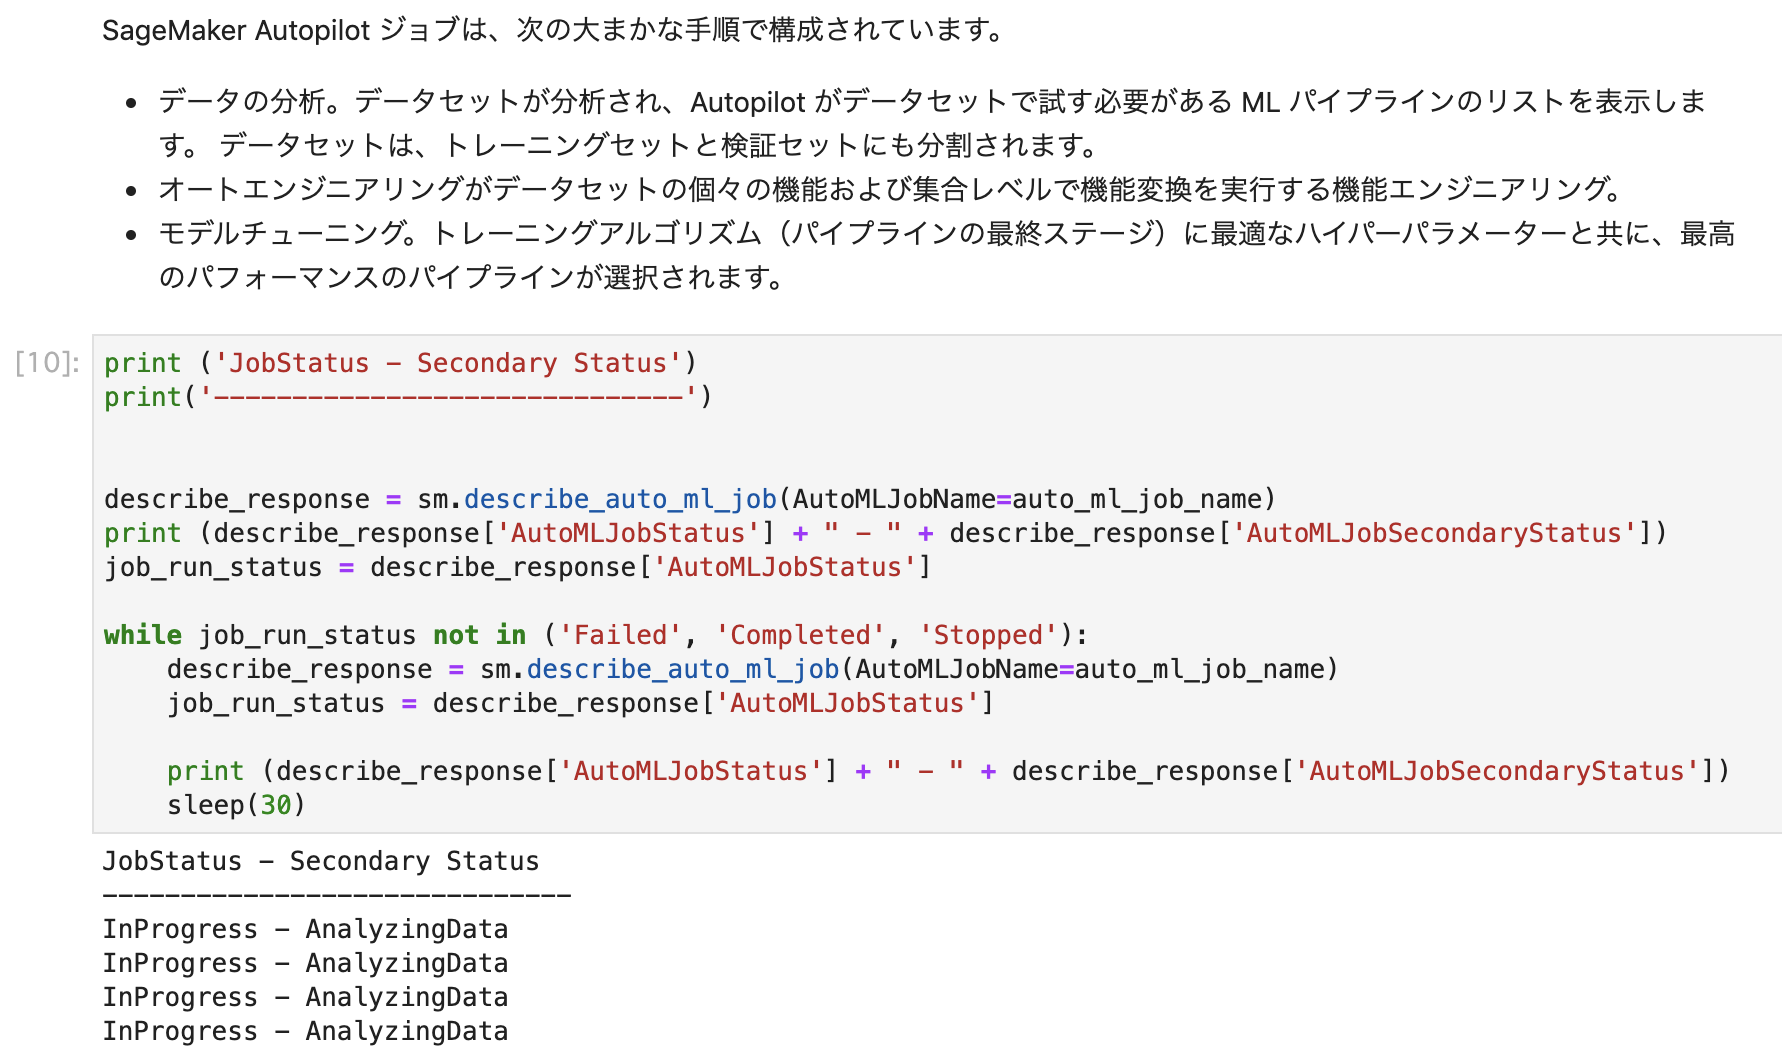

In [ ]:
print ('JobStatus - Secondary Status')
print('------------------------------')


describe_response = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)
print (describe_response['AutoMLJobStatus'] + " - " + describe_response['AutoMLJobSecondaryStatus'])
job_run_status = describe_response['AutoMLJobStatus']
    
while job_run_status not in ('Failed', 'Completed', 'Stopped'):
    describe_response = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)
    job_run_status = describe_response['AutoMLJobStatus']
    
    print (describe_response['AutoMLJobStatus'] + " - " + describe_response['AutoMLJobSecondaryStatus'])
    sleep(30)

---
<a name="result"></a>

## 5. 結果

次に、describe_auto_ml_job API を使用して、SageMaker Autopilot ジョブによって選択された最適な候補を検索します。

In [ ]:
best_candidate = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)['BestCandidate']
best_candidate_name = best_candidate['CandidateName']
print(best_candidate)
print('\n')
print("CandidateName: " + best_candidate_name)
print("FinalAutoMLJobObjectiveMetricName: " + best_candidate['FinalAutoMLJobObjectiveMetric']['MetricName'])
print("FinalAutoMLJobObjectiveMetricValue: " + str(best_candidate['FinalAutoMLJobObjectiveMetric']['Value']))

---
<a name="evaluation"></a>

## 6. 評価
### 6.1. ホスティング

アルゴリズムのトレーニングが完了したので、モデルを作成して、ホストされたエンドポイントにデプロイします。

In [ ]:
timestamp_suffix = strftime('%d-%H-%M-%S', gmtime())
model_name = best_candidate_name + timestamp_suffix + "-model"
model_arn = sm.create_model(Containers=best_candidate['InferenceContainers'],
                            ModelName=model_name,
                            ExecutionRoleArn=role)

epc_name = best_candidate_name + timestamp_suffix + "-epc"
ep_config = sm.create_endpoint_config(EndpointConfigName = epc_name,
                                      ProductionVariants=[{'InstanceType': 'ml.m5.2xlarge',
                                                           'InitialInstanceCount': 1,
                                                           'ModelName': model_name,
                                                           'VariantName': 'main'}])

ep_name = best_candidate_name + timestamp_suffix + "-ep"
create_endpoint_response = sm.create_endpoint(EndpointName=ep_name,
                                              EndpointConfigName=epc_name)

In [ ]:
sm.get_waiter('endpoint_in_service').wait(EndpointName=ep_name)

### 6.2. 評価

ホストされたエンドポイントが実行されたので、http POST リクエストを行うだけで、モデルからリアルタイム予測を非常に簡単に行うことができます。 しかし、最初に、 `test_data` NumPy 配列をエンドポイントの背後のモデルに渡すために、シリアライザーとデシリアライザーをセットアップする必要があります。

In [ ]:
from io import StringIO
from sagemaker.predictor import RealTimePredictor
from sagemaker.content_types import CONTENT_TYPE_CSV


predictor = RealTimePredictor(
    endpoint=ep_name,
    sagemaker_session=session,
    content_type=CONTENT_TYPE_CSV,
    accept=CONTENT_TYPE_CSV)

# Remove the target column from the test data
test_data_inference = test_data.drop('Churn?', axis=1)

# Obtain predictions from SageMaker endpoint
prediction = predictor.predict(test_data_inference.to_csv(sep=',', header=False, index=False)).decode('utf-8')

# Load prediction in pandas and compare to ground truth
prediction_df = pd.read_csv(StringIO(prediction), header=None)
accuracy = (test_data.reset_index()['Churn?'] == prediction_df[0]).sum() / len(test_data_inference)
print('Accuracy: {}'.format(accuracy))

### 6.3. SageMaker Autopilot が探索した他のチューニングジョブ
SageMaker Autopilot によって探索されたすべての候補（さまざまなハイパーパラメーターの組み合わせによるパイプライン評価）を表示し、それらを最終的なパフォーマンスメトリックで並べ替えることができます。

In [ ]:
candidates = sm.list_candidates_for_auto_ml_job(AutoMLJobName=auto_ml_job_name, SortBy='FinalObjectiveMetricValue')['Candidates']
index = 1
for candidate in candidates:
  print (str(index) + "  " + candidate['CandidateName'] + "  " + str(candidate['FinalAutoMLJobObjectiveMetric']['Value']))
  index += 1

### 6.4. 自動生成ノートブック
#### 候補生成ノートブック
Sagemaker AutoPilot は、候補探索過程のノートブックも自動生成します。 このノートブックを使用すると、Sagemaker Autopilot が実行するさまざまな手順をインタラクティブに実行して、最適な候補を見つけることができます。 このノートブックは、並列処理、使用されるハードウェア、探索されるアルゴリズム、特徴抽出スクリプトなどのさまざまなランタイムパラメーターをオーバーライドするためにも使用できます。

In [ ]:
candidate_definition = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)['AutoMLJobArtifacts']['CandidateDefinitionNotebookLocation']
!aws s3 cp {candidate_definition} ./

#### データ探索ノートブック
Sagemaker Autopilot は、Data Exploration の過程のノートブックも自動生成します。

In [1]:
data_exploration = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)['AutoMLJobArtifacts']['DataExplorationNotebookLocation']
!aws s3 cp {data_exploration} ./

NameError: name 'sm' is not defined

`SageMakerAutopilotCandidateDefinitionNotebook.ipynb` と `SageMakerAutopilotDataExplorationNotebook.ipynb` が、本ノートブックと同じローカルフォルダに出力されました。

---
<a name="cleanup"></a>

## 7. 後片付け

Autopilot ジョブは、データセットの分割、前処理スクリプト、前処理されたデータなど、多くの主要なアーティファクトを作成します。下記のコードのコメントを外すと、これらは削除されます。 この操作により、生成されたすべてのモデルと自動生成されたノートブックも削除されます。

In [ ]:
s3 = boto3.resource('s3')
s3_bucket = s3.Bucket(bucket)

job_outputs_prefix = '{}/output/{}'.format(prefix, auto_ml_job_name)
s3_bucket.objects.filter(Prefix=job_outputs_prefix).delete()

最後に、エンドポイントと関連するリソースを削除します。

In [ ]:
sm.delete_endpoint(EndpointName=ep_name)
sm.delete_endpoint_config(EndpointConfigName=epc_name)
sm.delete_model(ModelName=model_name)